# TA Review 1
*1/14/2025*

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Burak Sekerci
* bsekerci@uchicago.edu

### Agenda
**Week 1 Topics**
- Treasury Products Basics
- Yield Curve and its components
- How to go from YTMs to the yield curve and to the discount factors:
    - Mapping Cashflows
    - Solving for YTM
    - Bootstrapping vs OLS vs Nelson-Siegel <br>

## Treasury Products Basics

### Treasury Bills vs Notes vs Bonds ###

![Screenshot 2025-01-12 at 4.14.34 PM.png](<attachment:Screenshot 2025-01-12 at 4.14.34 PM.png>)
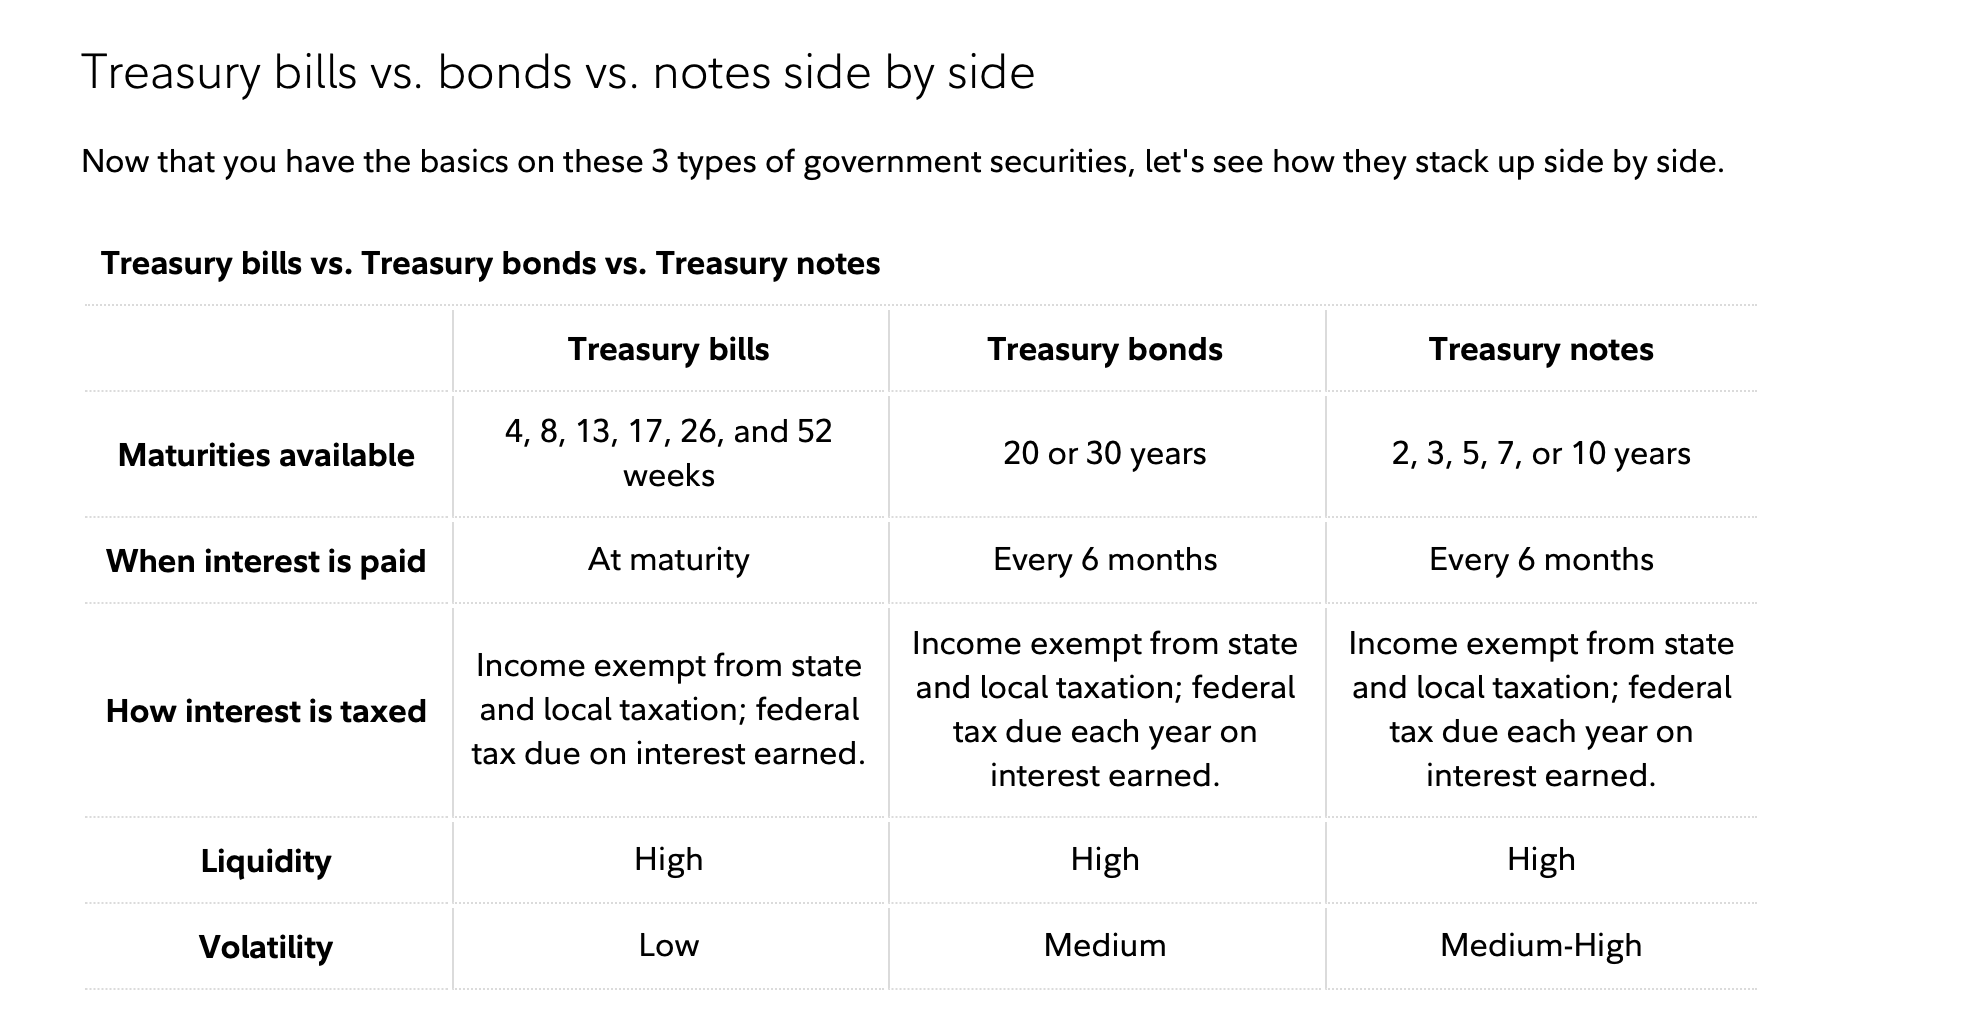

### TIPS vs Nominal ###

 - TIPS: Inflation adjusted treasury fixed income products. The principal value of the bond adjusts based on inflation, which in turn causes the coupon payments to fluctuate given they are calculated on top of the principal. This way the investor is protected against inflation changes. 


![Screenshot 2025-01-12 at 4.18.20 PM.png](<attachment:Screenshot 2025-01-12 at 4.18.20 PM.png>)
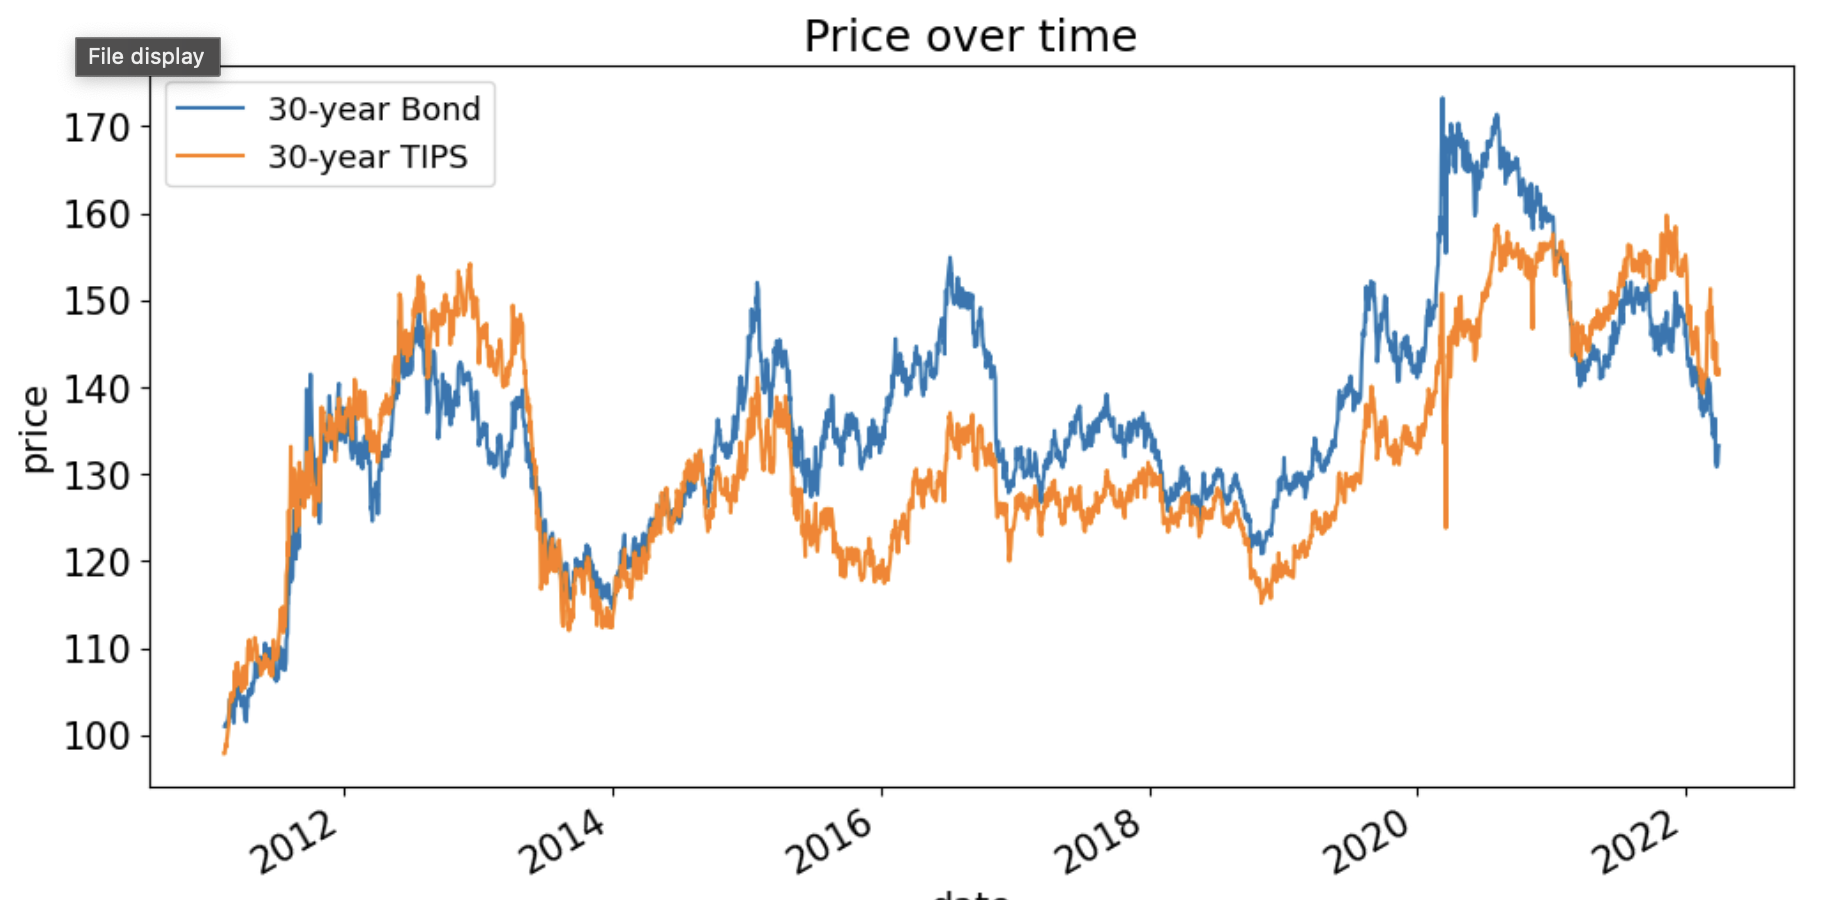

## Yield Curve and It's Components

The yield curve is a snapshot in time of the spot rates at different maturities. It gives you a cross section of the interest rate environment of the United States. It is calculated using the United States tresury products prices, and it is subject to change as the prices of these securities change as well.

https://www.ustreasuryyieldcurve.com

## How to go from YTMs to the Yield Curve and to the Discount Factors?

### Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

### Data

In [2]:
QUOTE_DATE = '2024-10-31'
filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')

In [3]:
rawdata

,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
0,208246,bill,2024-10-31,2024-07-09,2024-11-05,0.013689,0.972621,0.000,99.947806,99.947917,99.947861,0.000000,99.947861,0.038463
1,208222,bill,2024-10-31,2024-05-09,2024-11-07,0.019165,0.961670,0.000,99.922356,99.922522,99.922439,0.000000,99.922439,0.040899
2,208247,bill,2024-10-31,2024-07-16,2024-11-12,0.032854,0.934292,0.000,99.857458,99.857764,99.857611,0.000000,99.857611,0.043844
3,208223,bill,2024-10-31,2024-05-16,2024-11-14,0.038330,0.923340,0.000,99.832571,99.832932,99.832751,0.000000,99.832751,0.044151
4,204083,bond,2024-10-31,1994-05-15,2024-11-15,0.041068,0.918478,7.500,100.114004,100.114405,100.114204,3.444293,103.558498,0.045497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,208149,bond,2024-10-31,2023-11-15,2053-11-15,29.040383,0.918478,4.750,104.281250,104.335938,104.308594,2.181386,106.489980,0.044837
444,208191,TIPS note,2024-10-31,2024-02-15,2054-02-15,29.292266,0.000000,2.125,98.965129,99.137004,99.051066,0.000000,99.051066,NaN
445,208178,bond,2024-10-31,2024-02-15,2054-02-15,29.292266,0.418478,4.250,96.125000,96.171875,96.148438,0.889266,97.037704,0.044873
446,208233,bond,2024-10-31,2024-05-15,2054-05-15,29.535934,0.918478,4.625,102.328125,102.390625,102.359375,2.123981,104.483356,0.044809


In [4]:
column_mapping = {"quote date"    : "CALDT", 
                  "maturity date" : "TMATDT",
                  "bid"           : "TDBID",
                  "ask"           : "TDASK",
                  "accrued int"   : "TDACCINT",
                  "type"          : "ITYPE",
                  "cpn rate"      : "TCOUPRT",
                  "ytm"           : "TDYLD"
                  }

In [5]:
# Set params and import rawdata
QUOTE_DATE = '2024-10-31'
filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.rename(columns=column_mapping,inplace=True)
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

# Ensure data is all from the same quote date
t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

rawprices = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
rawprices.name = 'price'

maturity_delta = get_maturity_delta(rawdata['TMATDT'],t_current)
maturity_delta.name = 'maturity delta'
display(f'Treasuries quoted on {QUOTE_DATE}.')

'Treasuries quoted on 2024-10-31.'

# Mapping Cashflows
Important things to keep note:
- Is the data cleaned?
 - Restrict Yield: Ensure that yields are positive. There may be bad datapoints or illiquid securities with wide bid-asks that we do not want to model off of
 - Restrict TIPS: Cannot mix bonds and TIPS since TIPS use a different formula so by default, keep this true to remove them
 - Restrict Dates Maturing: This will filter out final maturity dates from the data, where you get back your face value
 - Restrict Redundant: This is helpful if we want to ensure 1 security per cashflow date
- Will it help to have cashflows defined for equal interval maturity dates (e.g., every 6 months)? This can help when handling forwards, swaps, etc.


#### Clean Data

In [6]:
RESTRICT_YLD = False
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, 
                         t_date=t_current, 
                         filter_yld = RESTRICT_YLD, 
                         filter_tips = RESTRICT_TIPS, 
                         drop_duplicate_maturities=RESTRICT_REDUNDANT)


In [7]:
data.head(100)

,ITYPE,CALDT,issue date,TMATDT,ttm,accrual fraction,TCOUPRT,TDBID,TDASK,price,TDACCINT,dirty price,TDYLD
KYTREASNO,,,,,,,,,,,,,
208246,bill,2024-10-31,2024-07-09,2024-11-05,0.013689,0.972621,0.000,99.947806,99.947917,99.947861,0.000000,99.947861,0.038463
208222,bill,2024-10-31,2024-05-09,2024-11-07,0.019165,0.961670,0.000,99.922356,99.922522,99.922439,0.000000,99.922439,0.040899
208247,bill,2024-10-31,2024-07-16,2024-11-12,0.032854,0.934292,0.000,99.857458,99.857764,99.857611,0.000000,99.857611,0.043844
208223,bill,2024-10-31,2024-05-16,2024-11-14,0.038330,0.923340,0.000,99.832571,99.832932,99.832751,0.000000,99.832751,0.044151
204083,bond,2024-10-31,1994-05-15,2024-11-15,0.041068,0.918478,7.500,100.114004,100.114405,100.114204,3.444293,103.558498,0.045497
...,...,...,...,...,...,...,...,...,...,...,...,...,...
207929,note,2024-10-31,2022-08-15,2025-08-15,0.788501,0.418478,3.125,99.027344,99.042569,99.034956,0.653872,99.688829,0.043870
207593,note,2024-10-31,2020-08-31,2025-08-31,0.832307,0.337017,0.250,96.640625,96.656293,96.648459,0.042127,96.690586,0.043944
207246,note,2024-10-31,2018-08-31,2025-08-31,0.832307,0.337017,2.750,98.660938,98.676883,98.668910,0.463398,99.132308,0.043895


#### Calculate cashflows
The ***treasury_cmds.py*** file is very helpful! The calc_cashflows function essentially does the following steps:
1. For each security, get the coupon dates
2. Apply the coupon rate at each coupon date that is applicable. Note that this function assumes semiannual rates
3. Apply the principle amount of 100 at the maturity date

In [8]:
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

In [12]:
CF.head()

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208222,0.0,100.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208247,0.0,0.0,100.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208223,0.0,0.0,0.0,100.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204083,0.0,0.0,0.0,0.0,103.75,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Adjust to have monthly cashflows

In [13]:
CF_monthly = CF.resample('m',axis=1).sum()
CF_monthly.drop(columns=CF_monthly.columns[(CF_monthly==0).all()],inplace=True)
CF_monthly = CF_monthly.fillna(0).sort_index(axis=1)
CF_monthly

/var/folders/2v/x2l6x6852t599bjnhqck84ch0000gn/T/ipykernel_94305/2261640705.py:1: FutureWarning: DataFrame.resample with axis=1 is deprecated. Do `frame.T.resample(...)` without axis instead.
  CF_monthly = CF.resample('m',axis=1).sum()
/var/folders/2v/x2l6x6852t599bjnhqck84ch0000gn/T/ipykernel_94305/2261640705.py:1: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  CF_monthly = CF.resample('m',axis=1).sum()


,2024-11-30,2024-12-31,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,...,2052-05-31,2052-08-31,2052-11-30,2053-02-28,2053-05-31,2053-08-31,2053-11-30,2054-02-28,2054-05-31,2054-08-31
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
208222,100.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
208247,100.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
208223,100.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
204083,103.7500,0.0,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208149,2.3750,0.0,0.0,0.0000,0.0,0.0,2.3750,0.0,0.0,0.0000,...,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.0000,0.0000,0.000
208191,0.0000,0.0,0.0,1.0625,0.0,0.0,0.0000,0.0,0.0,1.0625,...,0.0000,1.0625,0.0000,1.0625,0.0000,1.0625,0.0000,101.0625,0.0000,0.000
208178,0.0000,0.0,0.0,2.1250,0.0,0.0,0.0000,0.0,0.0,2.1250,...,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,102.1250,0.0000,0.000


# Solving for YTM
Let $P_j(t,T,c)$ denote the price of 
- bond $j$ 
- observed time-$t$ 
- which matures at time $T$ 
- with coupons occuring at interim cashflow dates $T_i$ for $1\le i <n$
- and a final coupon and principal payment occuring at maturity $T$.
- Time to Maturity = T-t
- Assume par value of 100

Define the **yield-to-maturity** for bond $j$ as the term $y_j$ which satisfies the following equation:
 

![Screenshot 2025-01-13 at 8.14.42 PM.png](<attachment:Screenshot 2025-01-13 at 8.14.42 PM.png>)
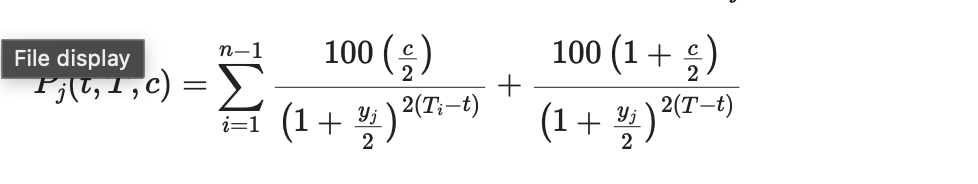


- This formula is a sum of the cashflows. The first part of the formula is the sum of the coupons. The 2nd part of the formula (outside of the summation) is adding back the face value. Note this also includes the last coupon payment as part of the par value paid back at maturity. 
- This equation assumes a semiannual coupon payment given the $\frac{c}{2}$ in the numerator. This can be explicitly changed to match whatever frequency is required.
- What does the YTM mean in this equation? Its the discount factor for each cashflow. This is because of the time-value of money. Therefore, this equation identifies the discount factor across all cashflows to arrive at any given bond's price. 

To solve for YTM, we must use a non-linear solver, such as fsolve from scipy. Using the above data, here are the following steps:

#### 1.  Calculate dirty price (include the coupon interest accrual)

In [14]:
px = (rawdata[['TDASK','TDBID']].mean(axis=1) + rawdata['TDACCINT']).loc[CF.index]

#### 2. Get Maturity Grid (The time difference between the maturity of the cashflows and the date of the quoted data divided by 365.25)

In [15]:
maturity_grid = pd.Series(get_maturity_delta(CF.columns.values,t_current=t_current),index=CF.columns)
maturity_grid

2024-11-05     0.013689
2024-11-07     0.019165
2024-11-12     0.032854
2024-11-14     0.038330
2024-11-15     0.041068
                ...    
2053-08-15    28.788501
2053-11-15    29.040383
2054-02-15    29.292266
2054-05-15    29.535934
2054-08-15    29.787817
Length: 335, dtype: float64

#### 3. Use fsolve to solve for YTM for each issue
fsolve Documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html

$$ PV = \frac{CF}{(1+\frac{r}{n})^{n\cdot(T-t)}}$$

In [16]:
def pv(rate, cashflows, maturities,freq=1):
    price = sum([cfi/(1+rate/freq)**(maturities[i]*freq) for i, cfi in enumerate(cashflows)])
    return price

In [17]:
# Create an object to store all the ytm's. Remeber that each bond has a unique YTM!
ytm = pd.Series(index=px.index,dtype=float)
# For each bond, create a functon that is equal to the current price less the present value.
# The optimization then identifies the variable, YTM, that makes the function equal 0
for idbond in px.index:
    pv_wrapper = lambda y: px.loc[idbond] - pv(y,CF.loc[idbond,:].values,maturity_grid.values,freq=2)
    ytm.loc[idbond] = fsolve(pv_wrapper,.01)

In [18]:
ytm

KYTREASNO
208246    0.038463
208222    0.040899
208247    0.043844
208223    0.044151
204083    0.045497
            ...   
208149    0.044837
208191    0.021896
208178    0.044873
208233    0.044809
208279    0.044802
Length: 448, dtype: float64

### Additional Notes on YTM
- YTM has a nonlinear and inverse relationship with price. The compounding of the cashflows is the reason for the nonlinear relationship. As the time to maturity increases, the nonlinearity increases as could be seen in the lecture notes comparing 1 vs 10 vs 30 year zero-coupon bonds
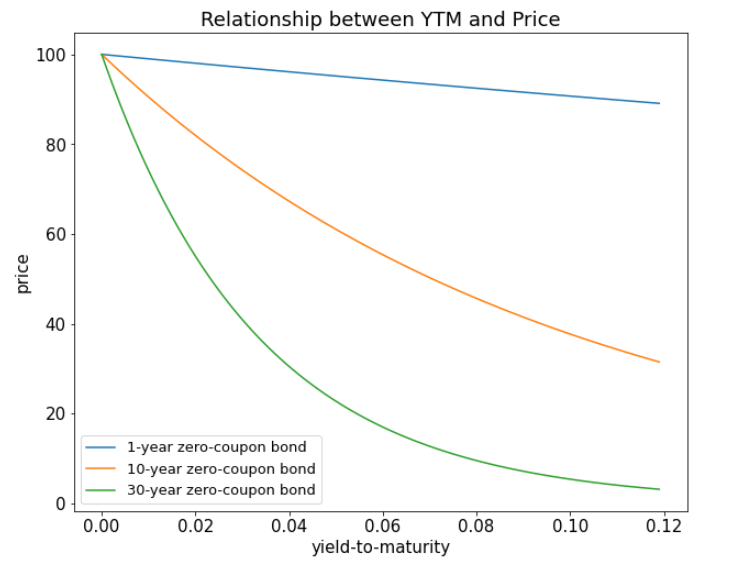
- YTM helps compare bonds against other bonds by showing the annual average return IF you can reinvest the coupons and you hold till maturity. 
- YTM is NOT the return because of the stylized assumptions noted above. Its the discount rate that would rationalize the bond. 


# YTM vs Spot Rates

- The spot rate does not depend on the specific bond like YTM does. It is a function of the cashflow timing and thus can be applied to any bond. 
- Within the formula, youll notice that the rate used is different for each time period
$$\begin{align*}
P_j(t,T,c) = \sum_{i=1}^{n-1}\frac{100\left(\frac{c}{2}\right)}{\left(1+\frac{r(t,T_i)}{2}\right)^{2(T_i-t)}} + \frac{100\left(1+\frac{c}{2}\right)}{\left(1+\frac{r(t,T)}{2}\right)^{2(T-t)}}
\end{align*}
$$

# How do we find the spot rates? - Bootstrapping vs OLS vs Nelson-Siegel

**Bootstrapping** <br>
If $n=k$, 
* perfectly identified system of equations
* no need for error, $\epsilon$
* **solve** with linear system of equations
* This usually requires curating the data (i.e., removing issues that seem wrong or less accurate so youre left with a subset)
* Common issues include **Biased Data and not having a perfectly identified system to run on**

In [19]:
CFset = {'all dates, including negative YTM quotes':CF}


To make this system square, we make sure to get rid of duplicate issues at each maturity and also the final maturity dates. This way we have one issue per date. 

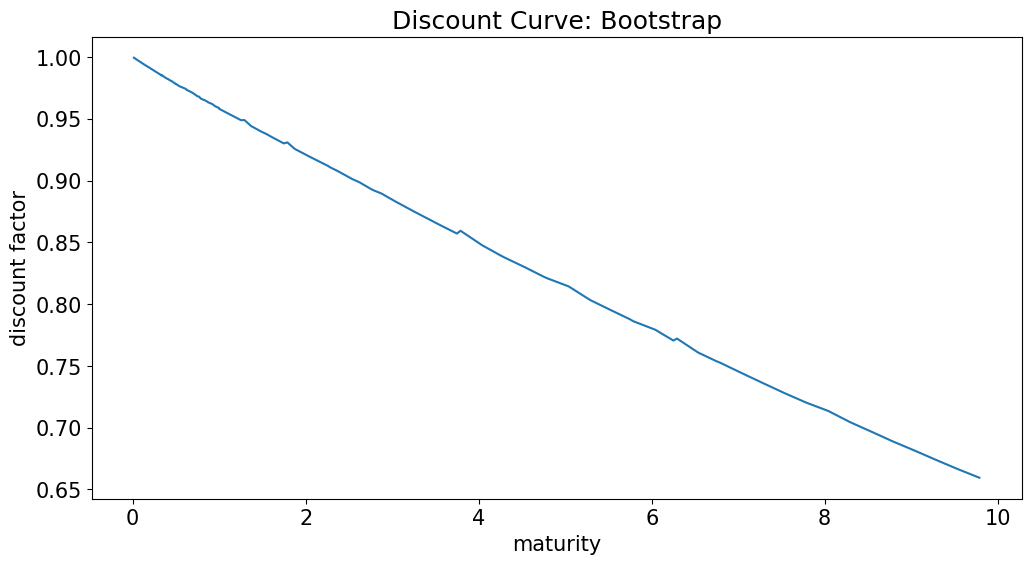

In [20]:
MODEL = bootstrap

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = True

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)
prices = rawdata['dirty price'][CF.index]

params_boot = estimate_rate_curve(MODEL,CF,t_current,prices)

label = 'single maturity per date, no non-maturity dates'
CFset[label] = CF

plt.plot(params_boot[0],params_boot[1])
plt.xlabel('maturity')
plt.ylabel('discount factor')
plt.title('Discount Curve: Bootstrap')
plt.show()

**OLS** <br>
If $n>k$,
* overidentified
* include $\epsilon$. This can be observation error (i.e., the price changes 1 second after initially reading the price) or liquidity impacts
* **estimate** with regression
* Do not need an intercept
* Common issues include **Multicollinearity & overfitting**


With respect to **Multicollinearity**:
* Having multiple treasuries with cashflows on dates without any treasury maturing means that it is impossible to identify the relative value of these coupons. Specifically, this cashflow matrix means the system of linear equations is undetermined. The discounts at the dates without maturities are unidentified by this system. Therefore expect that Boostrapping and OLS may struggle with estimation when this is the case!


This time we do not get rid of the duplicates in order to make an overidentified system. 

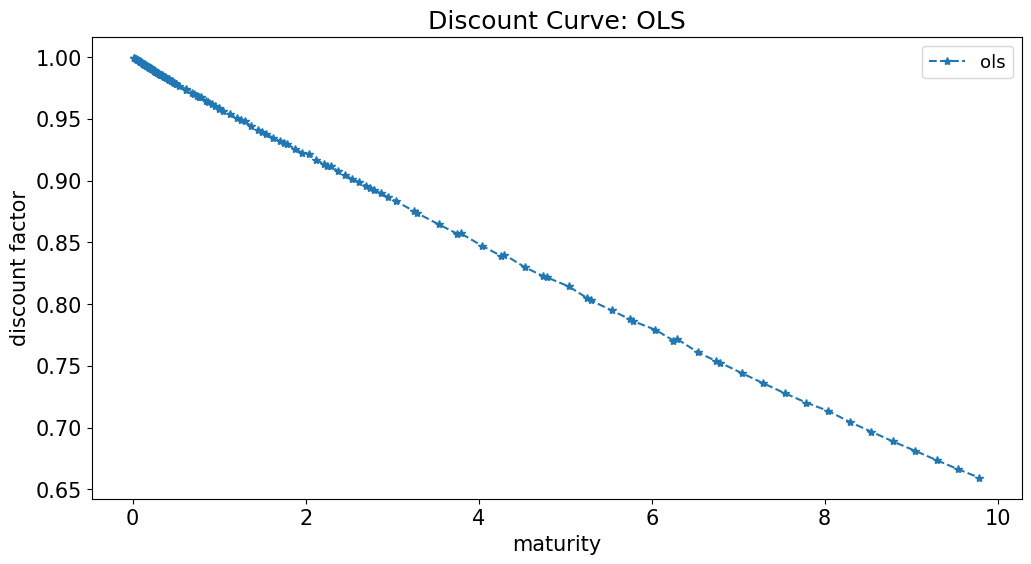

In [21]:
MODEL = bootstrap

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = True
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)
prices = rawdata['dirty price'][CF.index]

params_OLS = estimate_rate_curve(MODEL,CF,t_current,prices)
label = 'no non-maturity dates'
CFset[label] = CF

disc_ols = pd.DataFrame({'maturity':params_OLS[0], 'ols': params_OLS[1]}).set_index('maturity')
disc_ols.plot(marker='*',linestyle='--',ylabel='discount factor',title='Discount Curve: OLS')
plt.show()

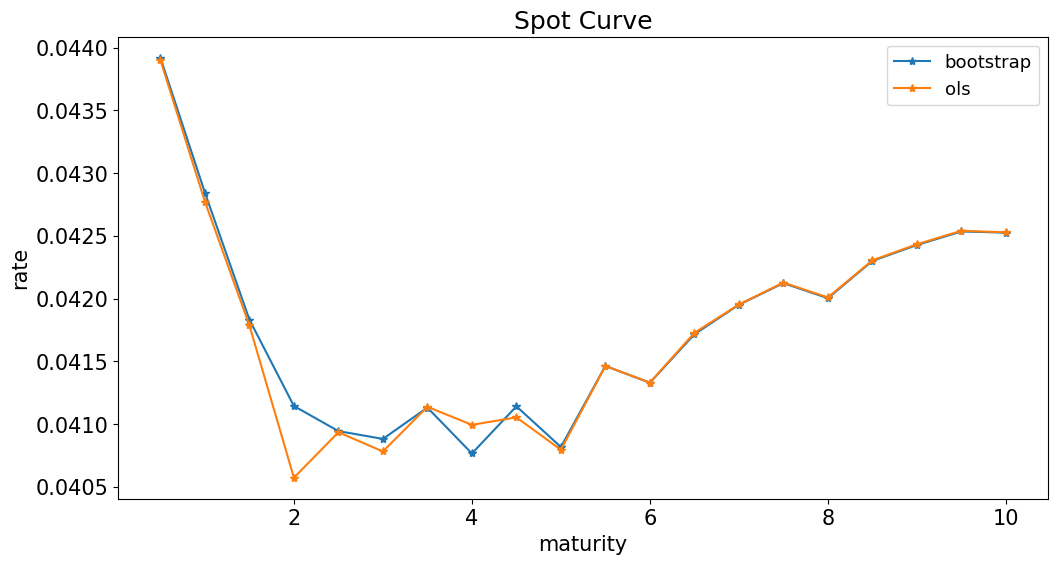

In [24]:
inc = .5

maturity_grid = np.arange(inc,disc_ols.index.to_series().max()+.5,inc)
curves_ols = pd.DataFrame(index = maturity_grid)
curves_ols['bootstrap'] = bootstrap(params_boot,maturity_grid)
curves_ols['ols'] = bootstrap(params_OLS,maturity_grid)

ax = curves_ols.plot(linestyle='-',marker='*',ylabel='rate',xlabel='maturity',title='Spot Curve')
plt.show()


**Nelson-Siegel** <br>
* Missing data
* Overfitting in-sample
* Allows all the data to be used to estimate the parameters of the model. This therefore improves the statistical power of the model because of all the data
* Common issues are the **biases introduced by the data if the true model is not represented by the data**. 

For the Nelson Siegal, we also do not get rid of the final maturity dates. This model allows us to capture the real shape of the yield curve by account for level, slope and curvature(PCA compotenents) of the fitted result. 

In [22]:
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

CFset['all dates'] = CF

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)
prices = rawdata['dirty price'][CF.index]

x0 = np.ones((4,))/10
params_NS = estimate_rate_curve(nelson_siegel,CF,t_current,prices,x0)

x0 = np.concatenate((params_NS,(0.1,0.1)))
params_NSE = estimate_rate_curve(nelson_siegel_extended,CF,t_current,prices,x0=x0)

tab_params_ns = pd.DataFrame(data = params_NS, index=['theta 0', 'theta 1', 'theta 2', 'lambda_1'],columns=['Nelson-Siegel']).T
tab_params_ns.loc[:,['theta_3', 'lambda_2']] = None
tab_params_ns.loc['Nelson-Siegel Extended',:] = params_NSE
tab_params_ns

/Users/aparnaambarapu/Documents/UChicago/Winter_2024/fixed_income/finm-fixedincome-2025/reviews/../cmds/treasury_cmds.py:264: RuntimeWarning: overflow encountered in exp
  rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3]) + params[4] *((1-np.exp(-maturity/params[5]))/(maturity/params[5]) - np.exp(-maturity/params[5]))
/Users/aparnaambarapu/Documents/UChicago/Winter_2024/fixed_income/finm-fixedincome-2025/reviews/../cmds/treasury_cmds.py:264: RuntimeWarning: invalid value encountered in scalar subtract
  rate = params[0] + (params[1] + params[2]) * (1 - np.exp(-maturity/params[3]))/(maturity/params[3]) - params[2] * np.exp(-maturity/params[3]) + params[4] *((1-np.exp(-maturity/params[5]))/(maturity/params[5]) - np.exp(-maturity/params[5]))
/Users/aparnaambarapu/Documents/UChicago/Winter_2024/fixed_income/finm-fixedincome-2025/reviews/../cmds/treasury_cmds.py:264: RuntimeWarning: overflow encounte

,theta 0,theta 1,theta 2,lambda_1,theta_3,lambda_2
Nelson-Siegel,0.047890,-0.002237,-0.020374,2.126944,None,None
Nelson-Siegel Extended,0.048571,-0.011136,-0.015605,2.121040,0.05678,0.078159


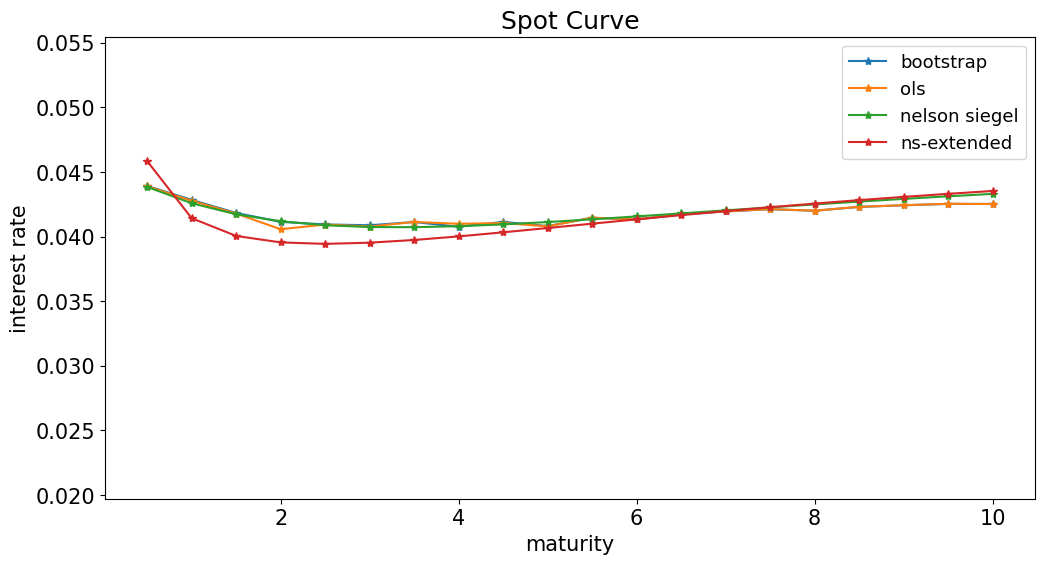

In [25]:
inc = .5

maturity_list = get_maturity_delta(list(CFset.values())[-1].columns,t_current=t_current)
maturity_grid = np.arange(inc,maturity_list.max()+.5,inc)
curves = pd.DataFrame(index = maturity_grid)
curves['nelson siegel'] = nelson_siegel(params_NS,maturity_grid)
curves['ns-extended']= nelson_siegel_extended(params_NSE,maturity_grid)

ax = curves_ols.plot(linestyle='-',marker='*')
curves.plot(ax=ax, linestyle='-',marker='*', ylim=(.5*curves.min().min(),1.1*curves.max().max()*1.1))

series_plotted = list(curves_ols.columns) + list(curves.columns)
plt.legend(series_plotted)
plt.xlabel('maturity')
plt.ylabel('interest rate')
plt.title('Spot Curve')
plt.show()

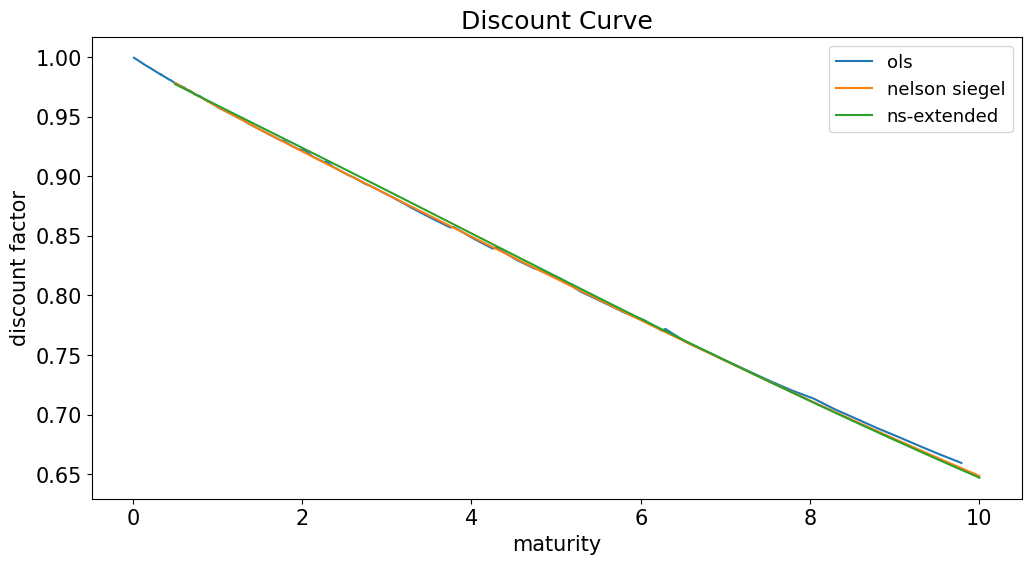

In [26]:
ax = disc_ols.plot()

zero_curve = intrate_to_discount(curves.loc[:,'nelson siegel'], maturity_grid, n_compound=None).to_frame()
zero_curve['ns-extended'] = intrate_to_discount(curves.loc[:,'ns-extended'], maturity_grid, n_compound=None).to_frame()
zero_curve.plot(ax=ax, title='Discount Curve', xlabel='maturity',ylabel='discount factor')

plt.show()